# Testing AG Coordinate 

This notebook evaluates the performance of the AG coordinate using a single density slice snapshot from the ANU-tub configuration. The AG coordinate is calculated using Angus' `pyale` package - these calculations are done within the notebook - see also `AG_VertRegrid.py` and `Evaluate_AG_Coord.ipynb` for a more thorough evaluation.

The `pyale` code is fortran-based, and pretty slow, so best to enable OpenMP to use multi-threading. Note that the cell below needs to be in the environment *before* OpenMP is initialised, which happens when you import the `pyale` module. Ideal is to match the number of threads with the number of cores available.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = str(14)

Import precompiled `pyale` code - note that you will need to match the python version here, or recompile to a newer version of python if that fails.

In [2]:
import toml
import sys
sys.path = ["/g/data/x77/ahg157/python-ale/build/lib.linux-x86_64-cpython-310"] + sys.path
import pyale

Import other standard plotting stuff.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm

## Load grid information into dataset

This just uses a random restart file copied locally.

In [4]:
restart_filename = '/g/data/x77/amh157/anu-tub/diagnostics/INPUTS/MOM.res.nc'

In [5]:
ds2 = xr.open_dataset(restart_filename)

0.3.0


Text(0.5, 1.0, 'Temperature')

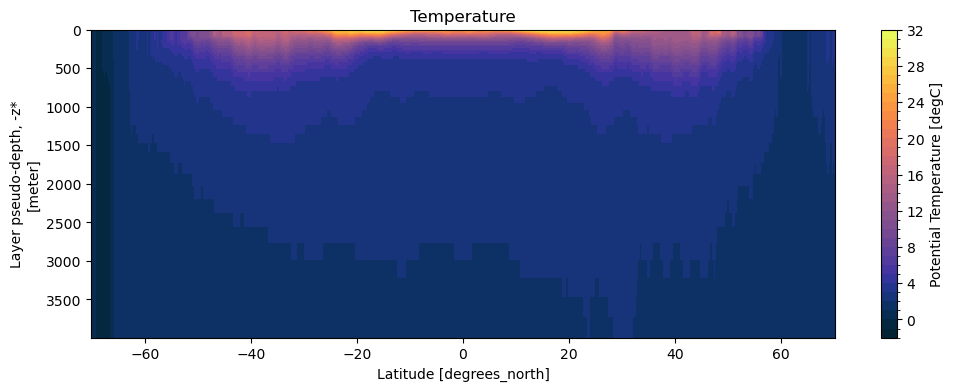

In [6]:
vlev = np.linspace(-2,32,35)
plt.figure(figsize=(12,4))
ds2.Temp.isel(Time=0).isel(lonh=39).plot(levels=vlev,cmap=cm.cm.thermal)
plt.gca().invert_yaxis()
plt.title('Temperature')

## Load Standard Adaptive Params
This function reads in the parameters from the default `.toml` file, and sets up the function. Note that we have optimised default parameters and specify updated parameters manually -- see `Evaluate_AG_Coord.ipynb` for details. 

In [7]:
params = toml.load("/g/data/x77/amh157/anu-tub/diagnostics/params_adapt.toml")
params["ADAPT_RESTORING_TIMESCALE"] = 5000000*86400        # default was 10 days
params["ADAPT_SMOOTH_MIN"] = 0.2                      # default is 0.1
cs = pyale.mom_init_cs(params); 

 log_version: MOM_domains                             , unknown
 MOM_domains                              REENTRANT_X:  T
 MOM_domains                              REENTRANT_Y:  F
 MOM_domains                              TRIPOLAR_N:  F
 MOM_domains                              OCEAN_OMP_THREADS:            1
 MOM_domains                              OCEAN_OMP_HYPER_THREAD:  F
 MOM_domains                              !SYMMETRIC_MEMORY_:  T
 MOM_domains                              NONBLOCKING_UPDATES:  F
 MOM_domains                              THIN_HALO_UPDATES:  T
 MOM_domains                              !STATIC_MEMORY_:  F
 MOM_domains                              NIGLOBAL:          160
 MOM_domains                              NJGLOBAL:          800
 MOM_domains                              NIHALO:            4
 MOM_domains                              NJHALO:            4
 MOM_domains                              MASKTABLE: 'MOM_mask_table'
 MOM_domains                         

In [8]:
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ADAPTIVE")

 init_MOM_state INPUTDIR: '/g/data/x77/amh157/mom6/input/anu-tub'
 init_MOM_state REGRIDDING_COORDINATE_UNITS: 'm'
 init_MOM_state INTERPOLATION_SCHEME: 'P1M_H2'
 init_MOM_state DEFAULT_2018_ANSWERS:  F
 init_MOM_state REMAPPING_2018_ANSWERS:  F
 init_MOM_state BOUNDARY_EXTRAPOLATION:  F
 init_MOM_state ALE_COORDINATE_CONFIG                   : 'FNC1:2,4000,4.5,.01'
 init_MOM_state !ALE_RESOLUTION                          :    2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0099999999999998        2.0099999999999998        2.0200000000000000        2.0299999999999998        2.0499999999999998        2.0800000000000001        2.1099999999999999        2.1499999999999999        2.2100000000000000        2.2800000000000002        2.3700000000000001        2.4800000000000000        2.6099999999999999        2.7700000000000000        2.9500000000000002     

In [9]:
def tpplot(field,h,vlev=50,cmap=cm.cm.thermal,title=''):
    plt.figure(figsize=(12,6))
    plt.subplot(211)
    p1 = field.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
    for ii in range(75):
        if np.mod(ii,10)==5:
            plt.plot(field.yh.values,h[:,ii],'m',linewidth=0.6)
        else:
            plt.plot(field.yh.values,h[:,ii],'w',linewidth=0.3)
    plt.ylim([0,500])
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.subplot(212)
    p1 = field.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
    for ii in range(75):
        if np.mod(ii,10)==5:
            plt.plot(field.yh.values,h[:,ii],'m',linewidth=0.6)
        else:
            plt.plot(field.yh.values,h[:,ii],'w',linewidth=0.3)
    plt.ylim([500,4000])
    plt.gca().invert_yaxis()
    plt.subplots_adjust(hspace=0)
    ax_c = plt.axes([0.92,0.3,0.01,0.4])
    plt.colorbar(p1,ax_c)

## Do first iteration, with diagnostics on

This will include the diagnostic outputs specified within the state vector, as a dictionary which can be obtained from `state[3]`. 

When we use that state vector for the next iteration, the diagnostics will stay switched on.

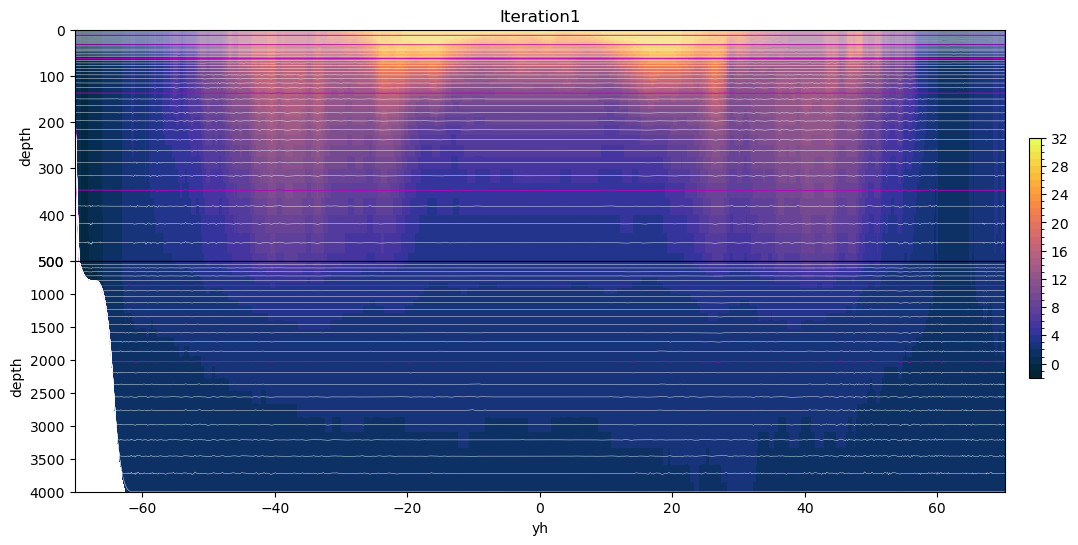

In [10]:
state = pyale.accelerate_ale(cs, adapt_cs, iter=1, dt=3600,diags=["adapt_disp_density","adapt_disp_smoothing","adapt_disp_unlimited"])

h=state[0]
temp=state[1]
salt=state[2]
diags = state[3]

h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
ii=1
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='Iteration'+str(ii))

Text(0.5, 1.0, 'total')

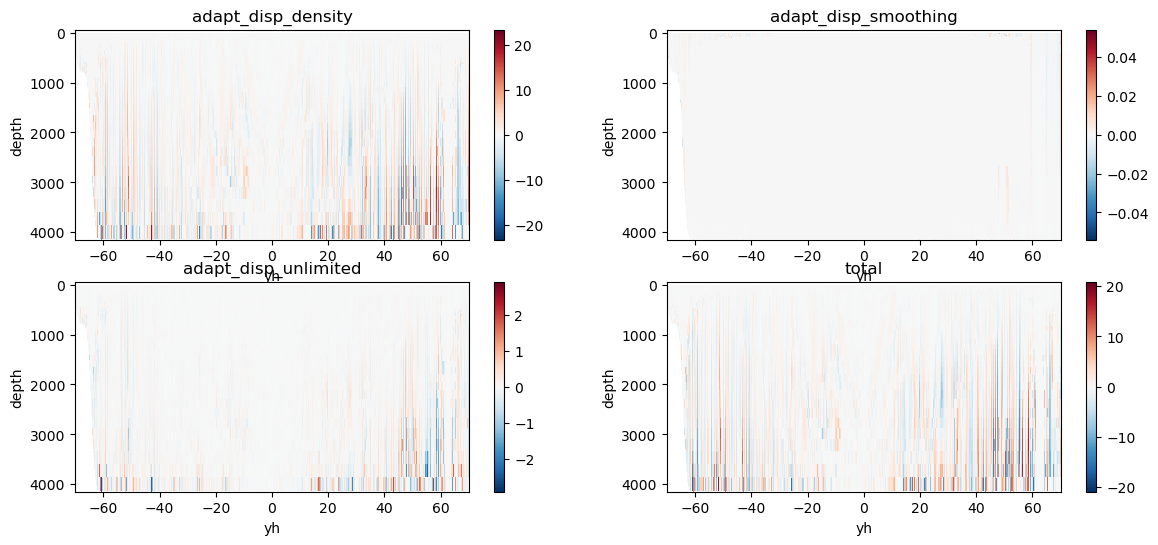

In [11]:
diag_density = xr.DataArray(data=np.transpose(diags['adapt_disp_density'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))   
plt.figure(figsize=(14,6))
plt.subplot(221)
p1 = diag_density.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_density')

diag_smoothing = xr.DataArray(data=np.transpose(diags['adapt_disp_smoothing'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(222)
p1 = diag_smoothing.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_smoothing')

diag_unlimited = xr.DataArray(data=np.transpose(diags['adapt_disp_unlimited'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(223)
p1 = diag_unlimited.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_unlimited')

diag_total = diag_density + diag_smoothing + diag_unlimited 
plt.subplot(224)
p1 = diag_total.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('total')

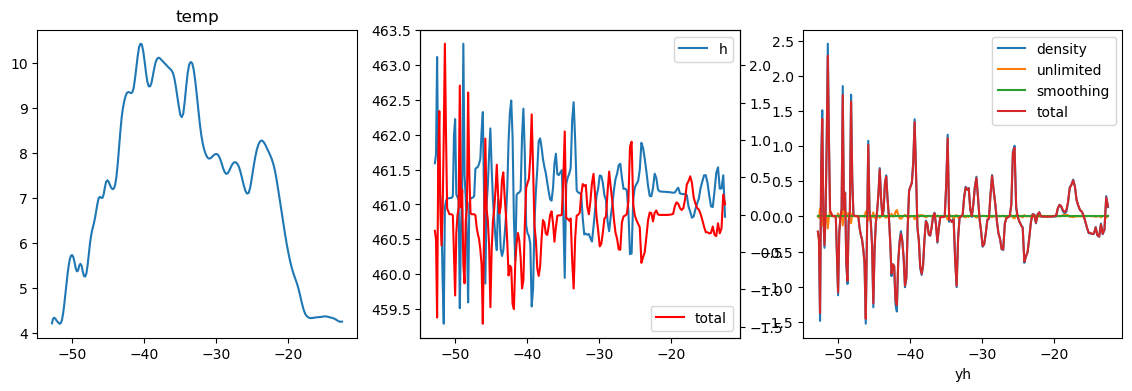

In [12]:
plt.figure(figsize=(14,4))

plt.subplot(131)
plt.plot(diag_total.yh[150:350],temp[39,150:350,45])
plt.title('temp')

ax = plt.subplot(132)
ax.plot(diag_total.yh[150:350],h_depth[150:350,48],label='h')
plt.legend()
ax2=ax.twinx()
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(ax=ax2,color='r',label='total')
plt.legend(loc=4)

plt.subplot(133)
diag_density.isel(zl=48).isel(yh=slice(150,350)).plot(label='density')
diag_unlimited.isel(zl=48).isel(yh=slice(150,350)).plot(label='unlimited')
diag_smoothing.isel(zl=48).isel(yh=slice(150,350)).plot(label='smoothing')
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(label='total')
plt.legend()

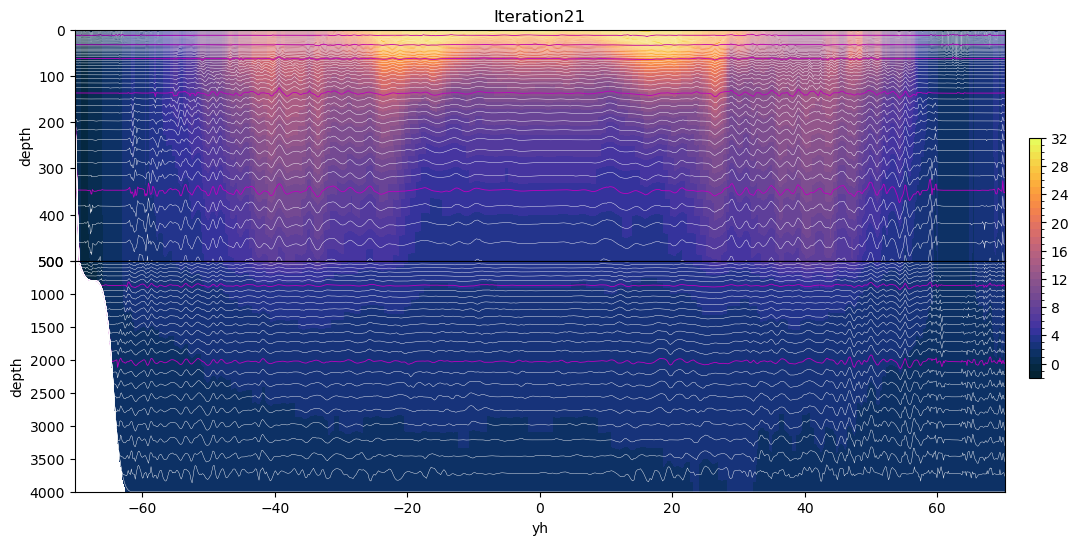

In [13]:
for ii in range(ii,ii+21):
    state = pyale.resume_ale(cs, adapt_cs, state, 1, dt=3600)

h=state[0]
temp=state[1]
salt=state[2]
diags = state[3]

h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
                coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))        
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='Iteration'+str(ii))

Text(0.5, 1.0, 'total')

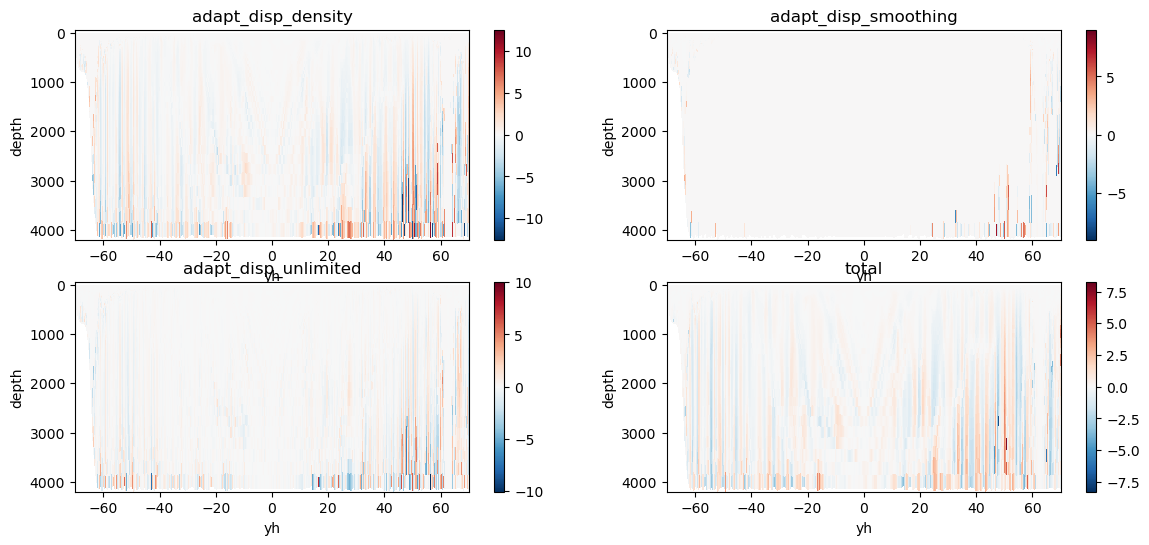

In [14]:
diag_density = xr.DataArray(data=np.transpose(diags['adapt_disp_density'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))   
plt.figure(figsize=(14,6))
plt.subplot(221)
p1 = diag_density.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_density')

diag_smoothing = xr.DataArray(data=np.transpose(diags['adapt_disp_smoothing'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(222)
p1 = diag_smoothing.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_smoothing')

diag_unlimited = xr.DataArray(data=np.transpose(diags['adapt_disp_unlimited'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(223)
p1 = diag_unlimited.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_unlimited')

diag_total = diag_density + diag_smoothing + diag_unlimited 
plt.subplot(224)
p1 = diag_total.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('total')

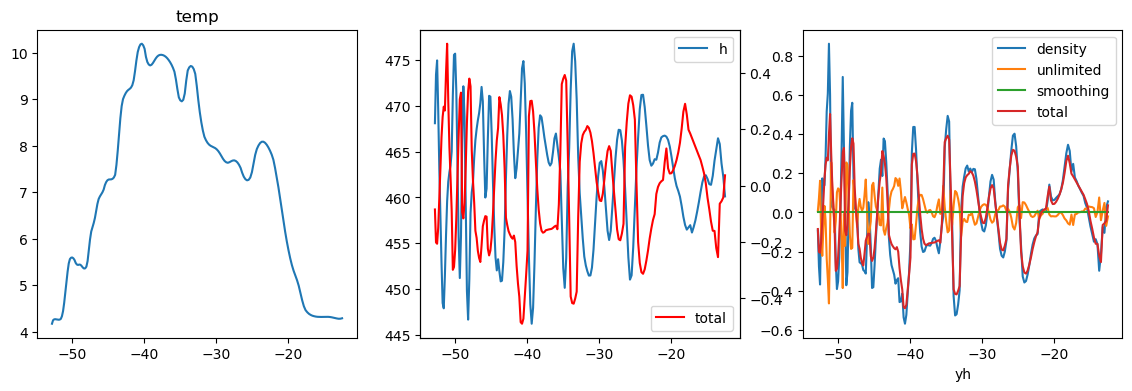

In [15]:
plt.figure(figsize=(14,4))

plt.subplot(131)
plt.plot(diag_total.yh[150:350],temp[39,150:350,45])
plt.title('temp')

ax = plt.subplot(132)
ax.plot(diag_total.yh[150:350],h_depth[150:350,48],label='h')
plt.legend()
ax2=ax.twinx()
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(ax=ax2,color='r',label='total')
plt.legend(loc=4)

plt.subplot(133)
diag_density.isel(zl=48).isel(yh=slice(150,350)).plot(label='density')
diag_unlimited.isel(zl=48).isel(yh=slice(150,350)).plot(label='unlimited')
diag_smoothing.isel(zl=48).isel(yh=slice(150,350)).plot(label='smoothing')
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(label='total')
plt.legend()

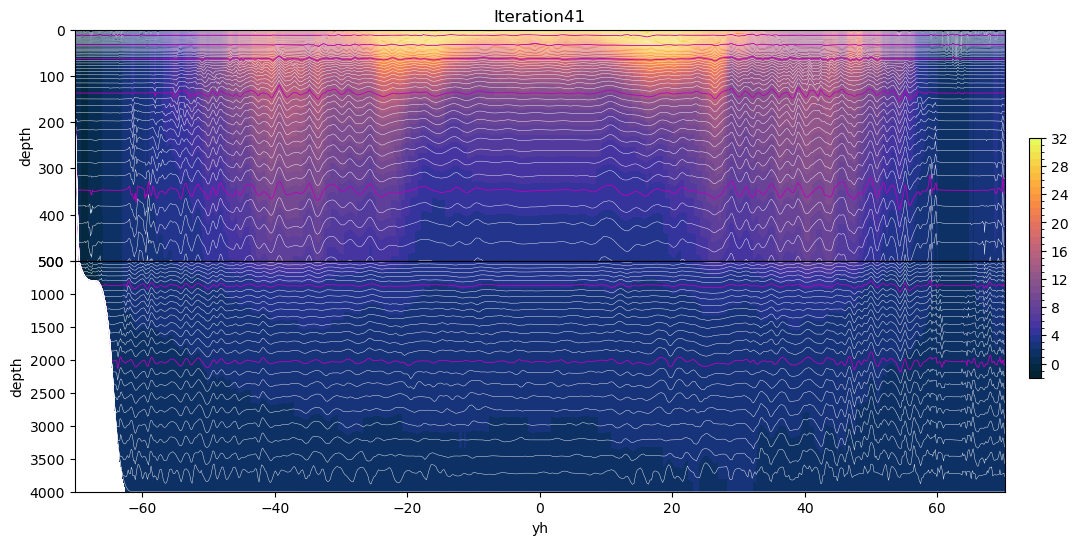

In [16]:
for ii in range(ii,ii+21):
    state = pyale.resume_ale(cs, adapt_cs, state, 1, dt=3600)

h=state[0]
temp=state[1]
salt=state[2]
diags = state[3]

h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
                coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))        
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='Iteration'+str(ii))

Text(0.5, 1.0, 'total')

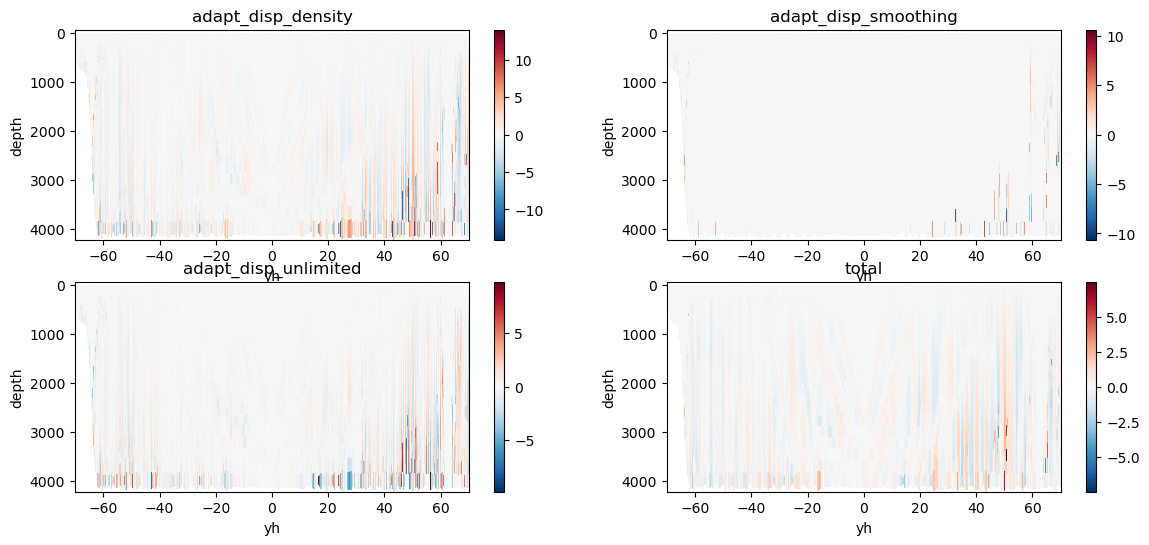

In [17]:
diag_density = xr.DataArray(data=np.transpose(diags['adapt_disp_density'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))   
plt.figure(figsize=(14,6))
plt.subplot(221)
p1 = diag_density.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_density')

diag_smoothing = xr.DataArray(data=np.transpose(diags['adapt_disp_smoothing'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(222)
p1 = diag_smoothing.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_smoothing')

diag_unlimited = xr.DataArray(data=np.transpose(diags['adapt_disp_unlimited'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(223)
p1 = diag_unlimited.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_unlimited')

diag_total = diag_density + diag_smoothing + diag_unlimited 
plt.subplot(224)
p1 = diag_total.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('total')

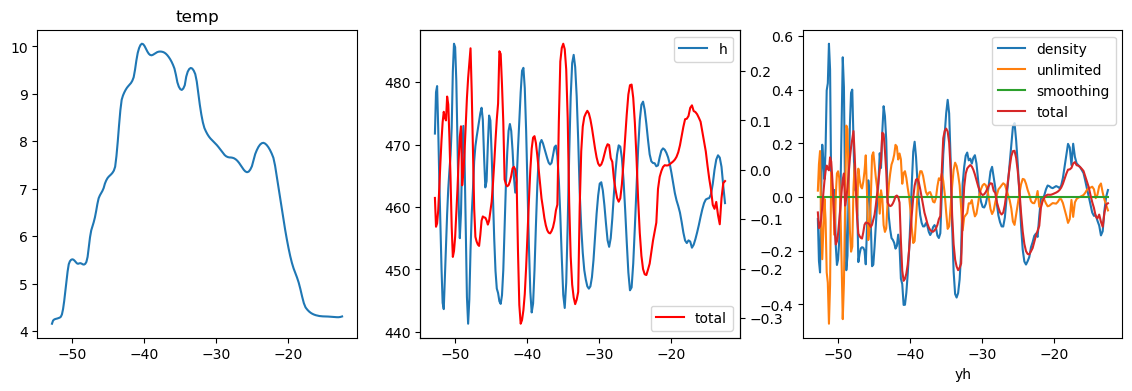

In [18]:
plt.figure(figsize=(14,4))

plt.subplot(131)
plt.plot(diag_total.yh[150:350],temp[39,150:350,45])
plt.title('temp')

ax = plt.subplot(132)
ax.plot(diag_total.yh[150:350],h_depth[150:350,48],label='h')
plt.legend()
ax2=ax.twinx()
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(ax=ax2,color='r',label='total')
plt.legend(loc=4)

plt.subplot(133)
diag_density.isel(zl=48).isel(yh=slice(150,350)).plot(label='density')
diag_unlimited.isel(zl=48).isel(yh=slice(150,350)).plot(label='unlimited')
diag_smoothing.isel(zl=48).isel(yh=slice(150,350)).plot(label='smoothing')
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(label='total')
plt.legend()

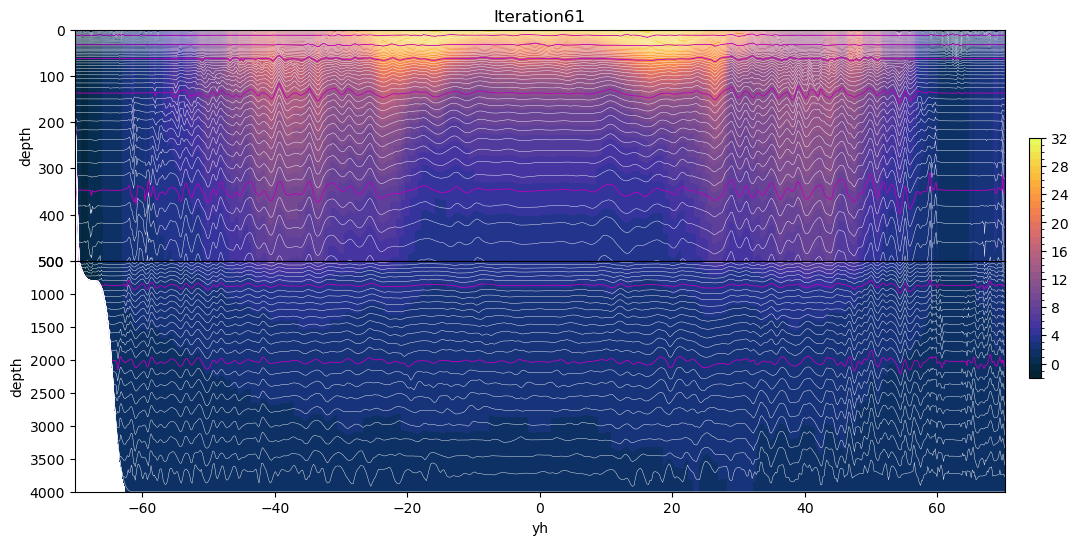

In [19]:
for ii in range(ii,ii+21):
    state = pyale.resume_ale(cs, adapt_cs, state, 1, dt=3600)

h=state[0]
temp=state[1]
salt=state[2]
diags = state[3]

h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
                coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))        
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='Iteration'+str(ii))

Text(0.5, 1.0, 'total')

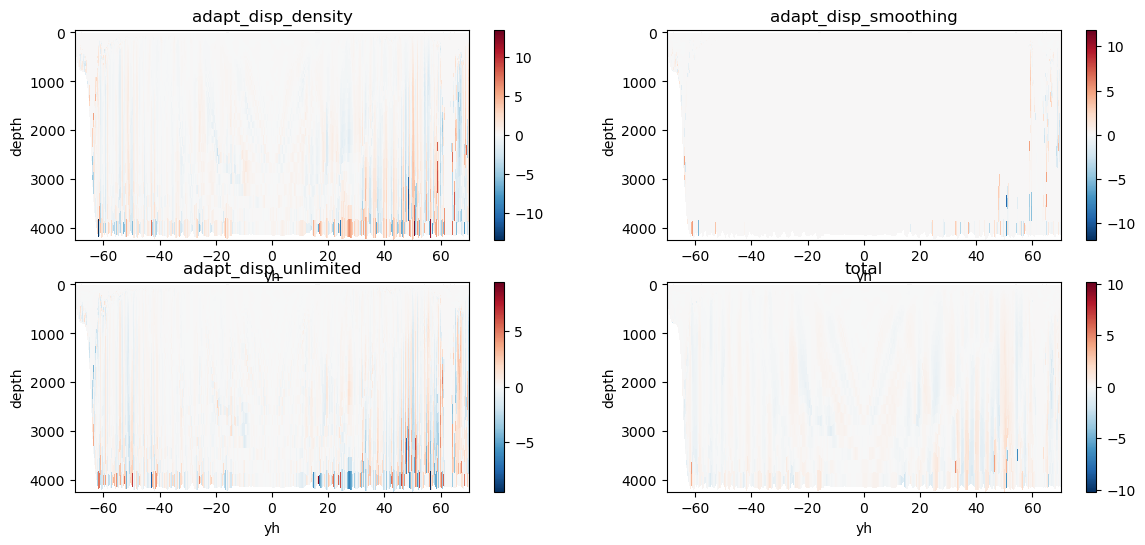

In [20]:
diag_density = xr.DataArray(data=np.transpose(diags['adapt_disp_density'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))   
plt.figure(figsize=(14,6))
plt.subplot(221)
p1 = diag_density.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_density')

diag_smoothing = xr.DataArray(data=np.transpose(diags['adapt_disp_smoothing'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(222)
p1 = diag_smoothing.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_smoothing')

diag_unlimited = xr.DataArray(data=np.transpose(diags['adapt_disp_unlimited'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(223)
p1 = diag_unlimited.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_unlimited')

diag_total = diag_density + diag_smoothing + diag_unlimited 
plt.subplot(224)
p1 = diag_total.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('total')

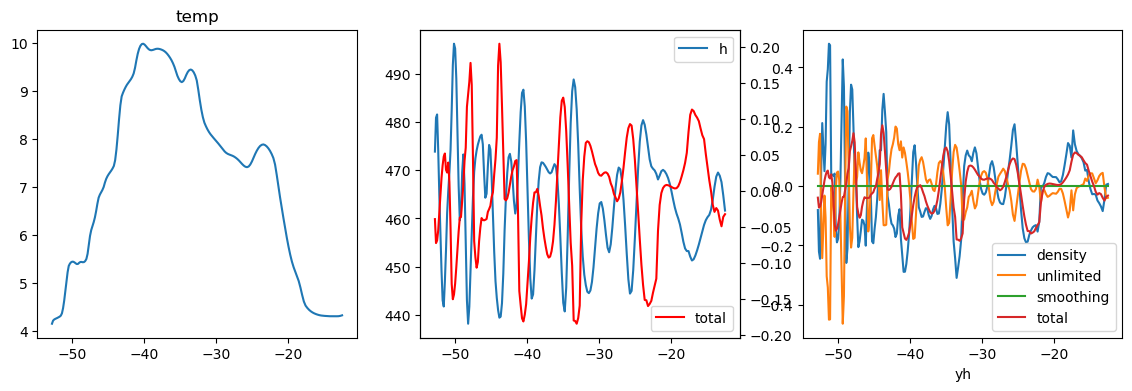

In [21]:
plt.figure(figsize=(14,4))

plt.subplot(131)
plt.plot(diag_total.yh[150:350],temp[39,150:350,45])
plt.title('temp')

ax = plt.subplot(132)
ax.plot(diag_total.yh[150:350],h_depth[150:350,48],label='h')
plt.legend()
ax2=ax.twinx()
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(ax=ax2,color='r',label='total')
plt.legend(loc=4)

plt.subplot(133)
diag_density.isel(zl=48).isel(yh=slice(150,350)).plot(label='density')
diag_unlimited.isel(zl=48).isel(yh=slice(150,350)).plot(label='unlimited')
diag_smoothing.isel(zl=48).isel(yh=slice(150,350)).plot(label='smoothing')
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(label='total')
plt.legend()

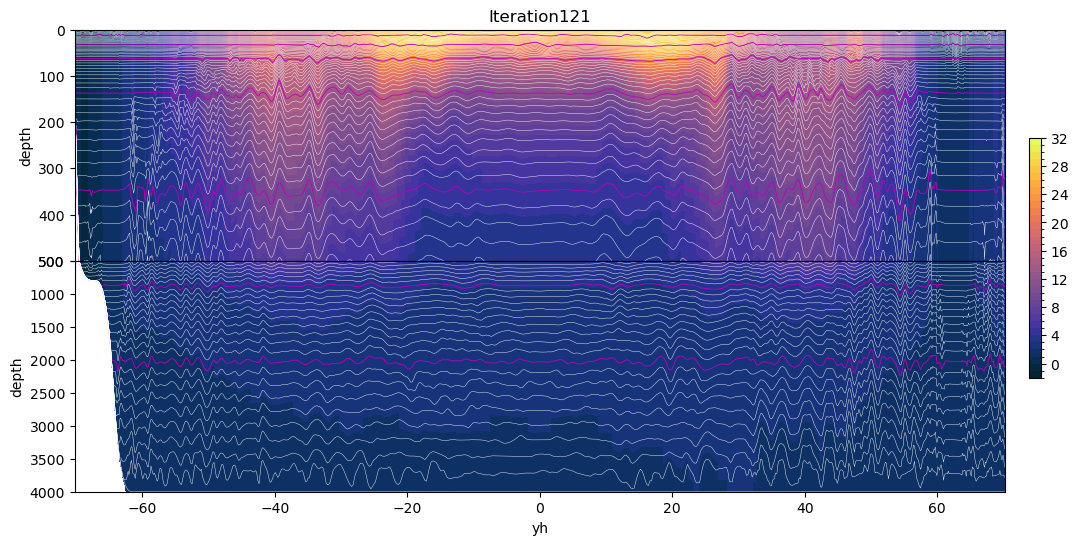

In [28]:
for ii in range(ii,ii+21):
    state = pyale.resume_ale(cs, adapt_cs, state, 1, dt=3600)

h=state[0]
temp=state[1]
salt=state[2]
diags = state[3]

h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
                coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))        
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='Iteration'+str(ii))

Text(0.5, 1.0, 'total')

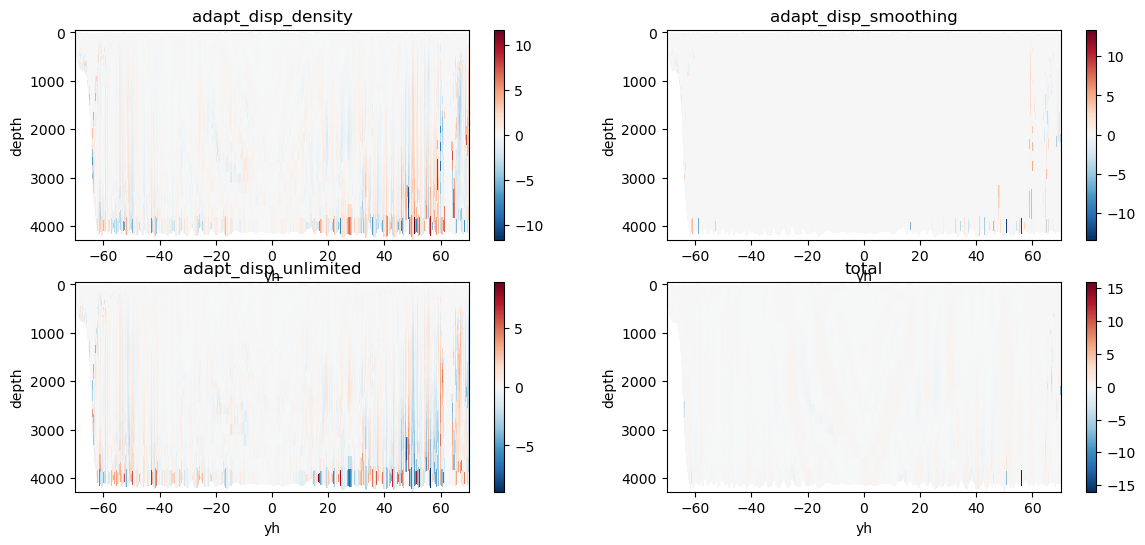

In [29]:
diag_density = xr.DataArray(data=np.transpose(diags['adapt_disp_density'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))   
plt.figure(figsize=(14,6))
plt.subplot(221)
p1 = diag_density.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_density')

diag_smoothing = xr.DataArray(data=np.transpose(diags['adapt_disp_smoothing'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(222)
p1 = diag_smoothing.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_smoothing')

diag_unlimited = xr.DataArray(data=np.transpose(diags['adapt_disp_unlimited'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(223)
p1 = diag_unlimited.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_unlimited')

diag_total = diag_density + diag_smoothing + diag_unlimited 
plt.subplot(224)
p1 = diag_total.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('total')

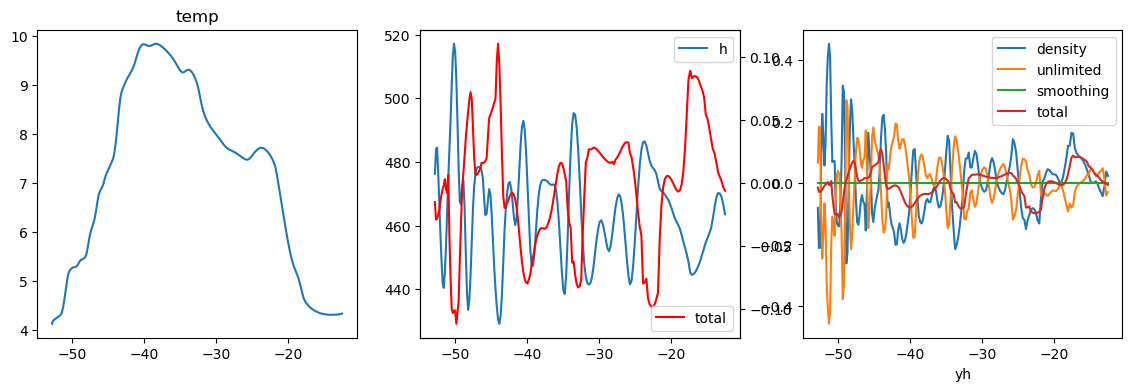

In [30]:
plt.figure(figsize=(14,4))

plt.subplot(131)
plt.plot(diag_total.yh[150:350],temp[39,150:350,45])
plt.title('temp')

ax = plt.subplot(132)
ax.plot(diag_total.yh[150:350],h_depth[150:350,48],label='h')
plt.legend()
ax2=ax.twinx()
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(ax=ax2,color='r',label='total')
plt.legend(loc=4)

plt.subplot(133)
diag_density.isel(zl=48).isel(yh=slice(150,350)).plot(label='density')
diag_unlimited.isel(zl=48).isel(yh=slice(150,350)).plot(label='unlimited')
diag_smoothing.isel(zl=48).isel(yh=slice(150,350)).plot(label='smoothing')
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(label='total')
plt.legend()

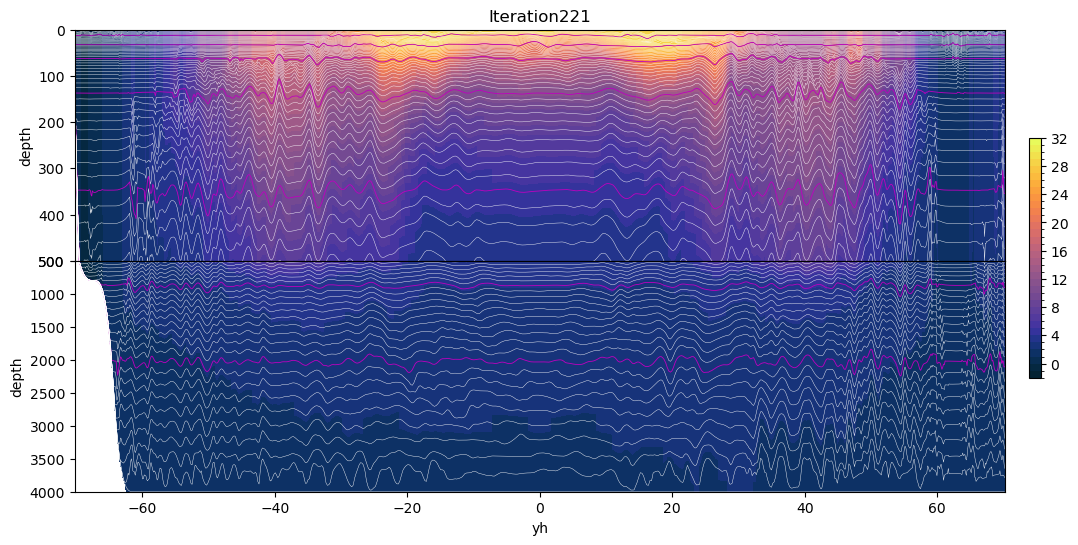

In [31]:
for ii in range(ii,ii+101):
    state = pyale.resume_ale(cs, adapt_cs, state, 1, dt=3600)

h=state[0]
temp=state[1]
salt=state[2]
diags = state[3]

h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
                coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))        
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='Iteration'+str(ii))

In [ ]:
diag_density = xr.DataArray(data=np.transpose(diags['adapt_disp_density'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))   
plt.figure(figsize=(14,6))
plt.subplot(221)
p1 = diag_density.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_density')

diag_smoothing = xr.DataArray(data=np.transpose(diags['adapt_disp_smoothing'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(222)
p1 = diag_smoothing.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_smoothing')

diag_unlimited = xr.DataArray(data=np.transpose(diags['adapt_disp_unlimited'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(223)
p1 = diag_unlimited.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_unlimited')

diag_total = diag_density + diag_smoothing + diag_unlimited 
plt.subplot(224)
p1 = diag_total.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('total')

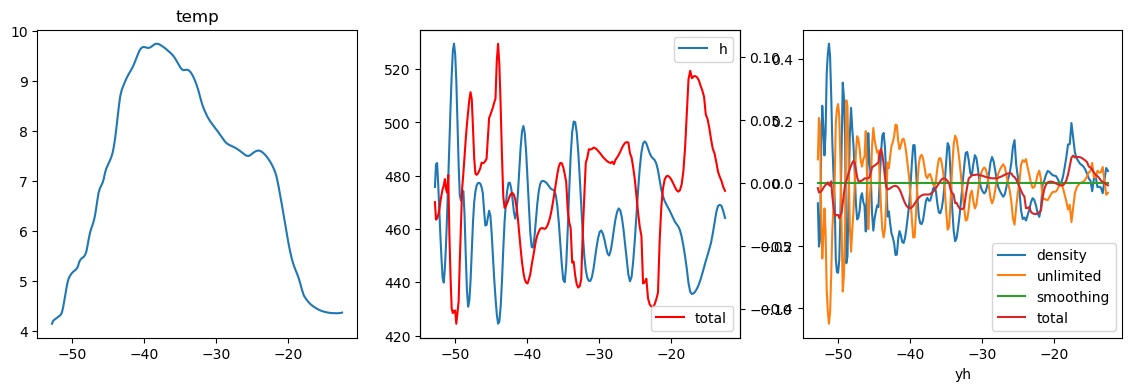

In [32]:
plt.figure(figsize=(14,4))

plt.subplot(131)
plt.plot(diag_total.yh[150:350],temp[39,150:350,45])
plt.title('temp')

ax = plt.subplot(132)
ax.plot(diag_total.yh[150:350],h_depth[150:350,48],label='h')
plt.legend()
ax2=ax.twinx()
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(ax=ax2,color='r',label='total')
plt.legend(loc=4)

plt.subplot(133)
diag_density.isel(zl=48).isel(yh=slice(150,350)).plot(label='density')
diag_unlimited.isel(zl=48).isel(yh=slice(150,350)).plot(label='unlimited')
diag_smoothing.isel(zl=48).isel(yh=slice(150,350)).plot(label='smoothing')
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(label='total')
plt.legend()

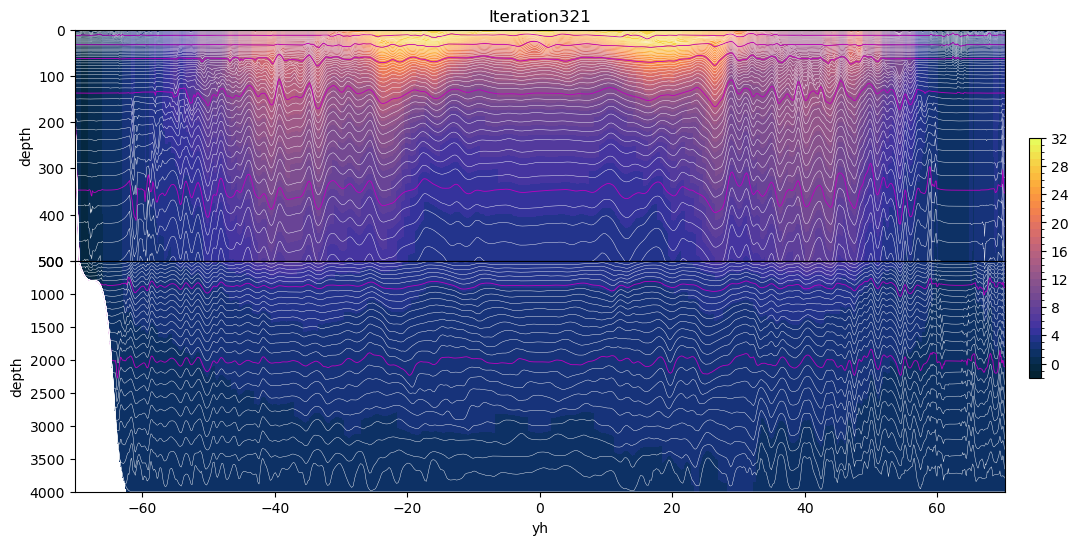

In [33]:
for ii in range(ii,ii+101):
    state = pyale.resume_ale(cs, adapt_cs, state, 1, dt=3600)

h=state[0]
temp=state[1]
salt=state[2]
diags = state[3]

h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
                coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))        
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='Iteration'+str(ii))

In [ ]:
diag_density = xr.DataArray(data=np.transpose(diags['adapt_disp_density'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))   
plt.figure(figsize=(14,6))
plt.subplot(221)
p1 = diag_density.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_density')

diag_smoothing = xr.DataArray(data=np.transpose(diags['adapt_disp_smoothing'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(222)
p1 = diag_smoothing.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_smoothing')

diag_unlimited = xr.DataArray(data=np.transpose(diags['adapt_disp_unlimited'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(223)
p1 = diag_unlimited.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_unlimited')

diag_total = diag_density + diag_smoothing + diag_unlimited 
plt.subplot(224)
p1 = diag_total.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('total')

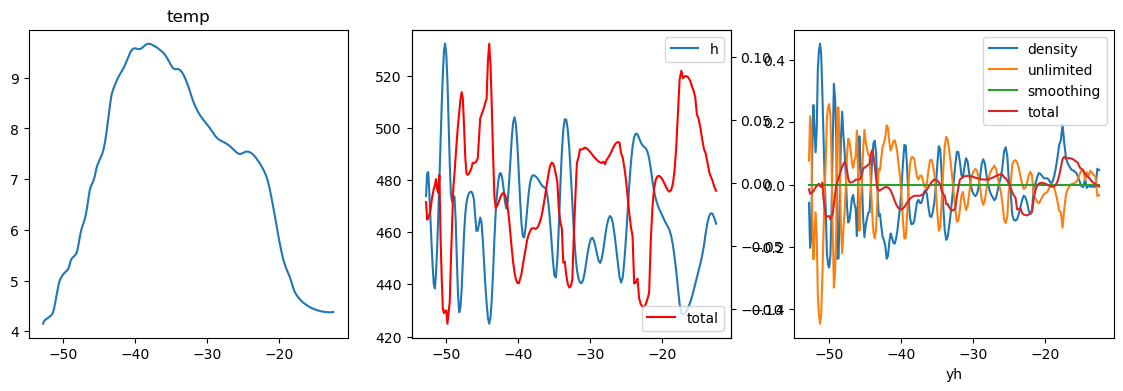

In [34]:
plt.figure(figsize=(14,4))

plt.subplot(131)
plt.plot(diag_total.yh[150:350],temp[39,150:350,45])
plt.title('temp')

ax = plt.subplot(132)
ax.plot(diag_total.yh[150:350],h_depth[150:350,48],label='h')
plt.legend()
ax2=ax.twinx()
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(ax=ax2,color='r',label='total')
plt.legend(loc=4)

plt.subplot(133)
diag_density.isel(zl=48).isel(yh=slice(150,350)).plot(label='density')
diag_unlimited.isel(zl=48).isel(yh=slice(150,350)).plot(label='unlimited')
diag_smoothing.isel(zl=48).isel(yh=slice(150,350)).plot(label='smoothing')
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(label='total')
plt.legend()

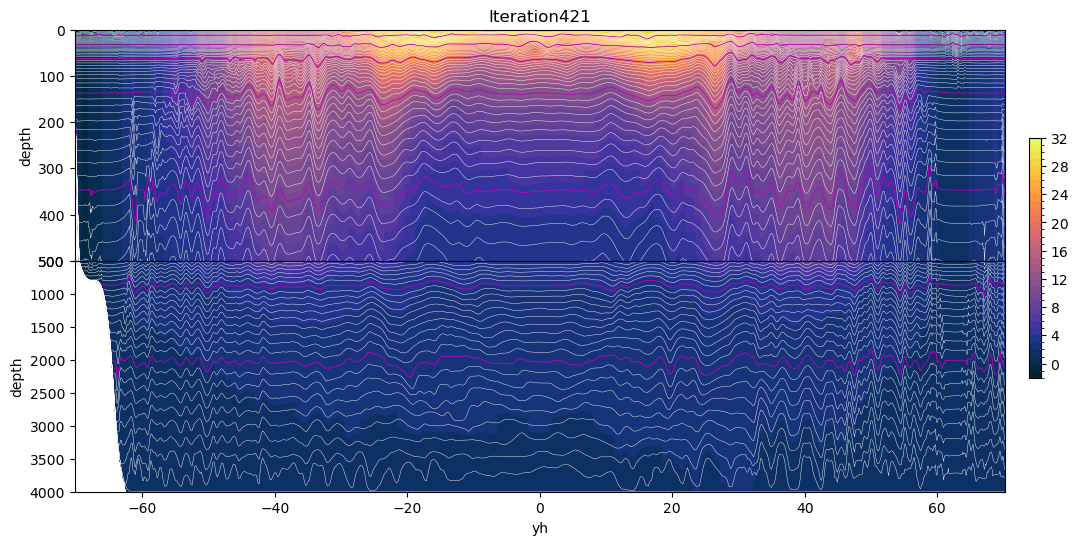

In [35]:
for ii in range(ii,ii+101):
    state = pyale.resume_ale(cs, adapt_cs, state, 1, dt=3600)

h=state[0]
temp=state[1]
salt=state[2]
diags = state[3]

h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
                coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))        
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='Iteration'+str(ii))

In [ ]:
diag_density = xr.DataArray(data=np.transpose(diags['adapt_disp_density'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))   
plt.figure(figsize=(14,6))
plt.subplot(221)
p1 = diag_density.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_density')

diag_smoothing = xr.DataArray(data=np.transpose(diags['adapt_disp_smoothing'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(222)
p1 = diag_smoothing.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_smoothing')

diag_unlimited = xr.DataArray(data=np.transpose(diags['adapt_disp_unlimited'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(223)
p1 = diag_unlimited.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_unlimited')

diag_total = diag_density + diag_smoothing + diag_unlimited 
plt.subplot(224)
p1 = diag_total.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('total')

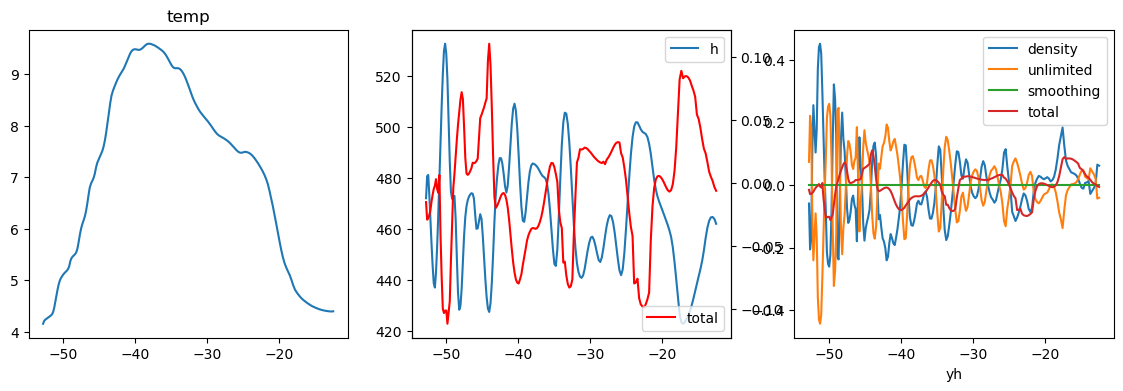

In [36]:
plt.figure(figsize=(14,4))

plt.subplot(131)
plt.plot(diag_total.yh[150:350],temp[39,150:350,45])
plt.title('temp')

ax = plt.subplot(132)
ax.plot(diag_total.yh[150:350],h_depth[150:350,48],label='h')
plt.legend()
ax2=ax.twinx()
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(ax=ax2,color='r',label='total')
plt.legend(loc=4)

plt.subplot(133)
diag_density.isel(zl=48).isel(yh=slice(150,350)).plot(label='density')
diag_unlimited.isel(zl=48).isel(yh=slice(150,350)).plot(label='unlimited')
diag_smoothing.isel(zl=48).isel(yh=slice(150,350)).plot(label='smoothing')
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(label='total')
plt.legend()

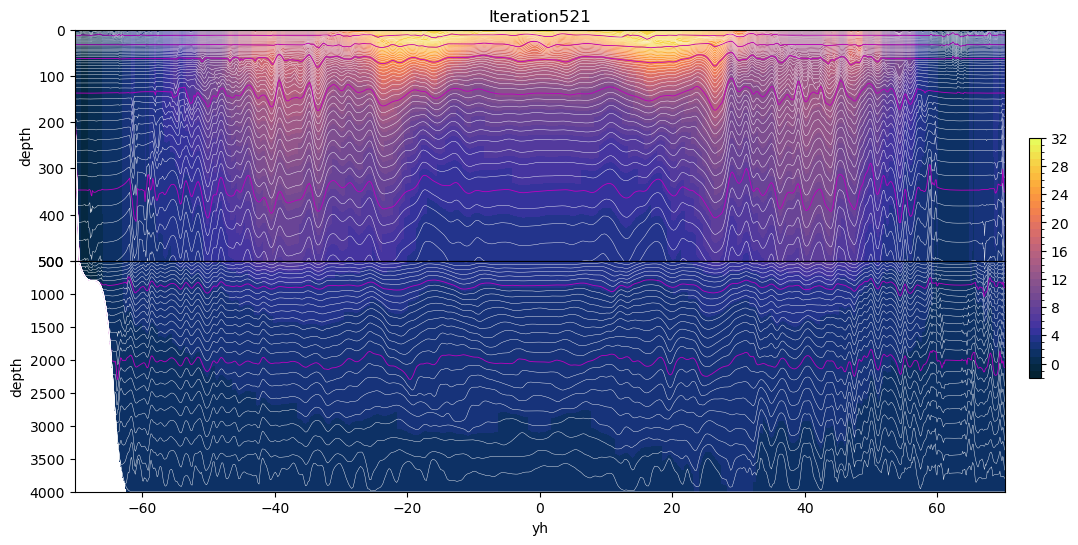

In [37]:
for ii in range(ii,ii+101):
    state = pyale.resume_ale(cs, adapt_cs, state, 1, dt=3600)

h=state[0]
temp=state[1]
salt=state[2]
diags = state[3]

h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
                coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))        
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='Iteration'+str(ii))

In [ ]:
diag_density = xr.DataArray(data=np.transpose(diags['adapt_disp_density'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))   
plt.figure(figsize=(14,6))
plt.subplot(221)
p1 = diag_density.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_density')

diag_smoothing = xr.DataArray(data=np.transpose(diags['adapt_disp_smoothing'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(222)
p1 = diag_smoothing.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_smoothing')

diag_unlimited = xr.DataArray(data=np.transpose(diags['adapt_disp_unlimited'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
plt.subplot(223)
p1 = diag_unlimited.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('adapt_disp_unlimited')

diag_total = diag_density + diag_smoothing + diag_unlimited 
plt.subplot(224)
p1 = diag_total.plot(y = "depth")
plt.gca().invert_yaxis()
plt.title('total')

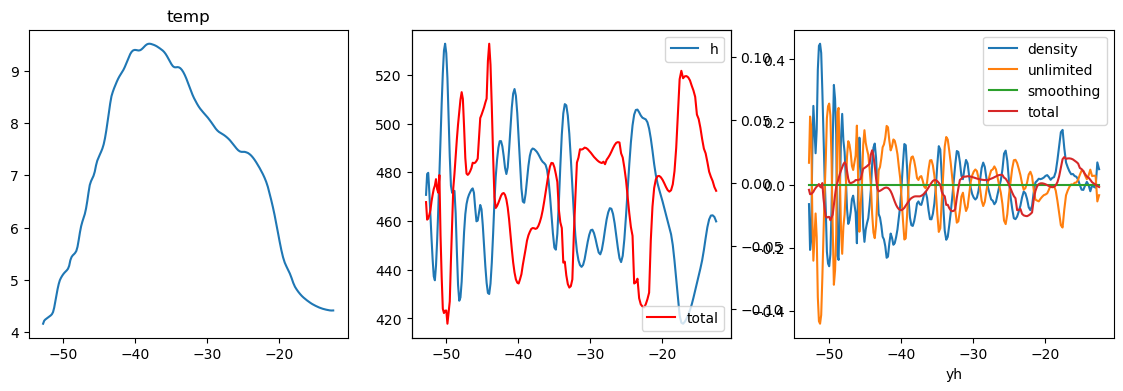

In [38]:
plt.figure(figsize=(14,4))

plt.subplot(131)
plt.plot(diag_total.yh[150:350],temp[39,150:350,45])
plt.title('temp')

ax = plt.subplot(132)
ax.plot(diag_total.yh[150:350],h_depth[150:350,48],label='h')
plt.legend()
ax2=ax.twinx()
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(ax=ax2,color='r',label='total')
plt.legend(loc=4)

plt.subplot(133)
diag_density.isel(zl=48).isel(yh=slice(150,350)).plot(label='density')
diag_unlimited.isel(zl=48).isel(yh=slice(150,350)).plot(label='unlimited')
diag_smoothing.isel(zl=48).isel(yh=slice(150,350)).plot(label='smoothing')
diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(label='total')
plt.legend()